# Synthetic photometry

In this tutorial, we will compute the synthetic [MKO J band](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=MKO/NSFCam.J&&mode=browse&gname=MKO&gname2=NSFCam#filter) flux from an [IRTF spectrum of Jupiter](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

## Getting started

We start by importing the required Python packages.

In [1]:
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import species

The [species](https://species.readthedocs.io/en/latest/species.html) database is initiated by creating an instance of the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.setup.SpeciesInit) class.

In [2]:
species.SpeciesInit()

Initiating species v0.3.1... [DONE]
Creating species_config.ini... [DONE]
Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Jupiter spectrum

The spectrum of Jupiter that is used as an example is now downloaded from the [IRTF website](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/Planets.html).

In [3]:
urllib.request.urlretrieve('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/plnt_Jupiter.txt',
                           'data/plnt_Jupiter.txt')

('data/plnt_Jupiter.txt', <http.client.HTTPMessage at 0x13e4e87f0>)

The file contains the wavelength in $\mu$m, and the flux and uncertainty in W m$^{-2}$ $\mu$m$^-1$, which are also the units that are required by [species](https://species.readthedocs.io/en/latest/species.html). We can read the data with [loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) from [numpy](https://numpy.org/).

In [4]:
wavelength, flux, error = np.loadtxt('data/plnt_Jupiter.txt', unpack=True)

Let's create a [SpectrumBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SpectrumBox) with the data.

In [5]:
spec_box = species.create_box('spectrum',
                              spectrum='irtf',
                              wavelength=wavelength,
                              flux=flux,
                              error=error,
                              name='jupiter')

And pass the [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function together with the filter name.

In [6]:
species.plot_spectrum(boxes=[spec_box, ],
                      filters=['MKO/NSFCam.J'],
                      xlim=(0.75, 1.8),
                      ylim=(-1e-9, 1.7e-8),
                      offset=(-0.1, -0.05),
                      figsize=(8., 4.),
                      output='spectrum.png')

Adding filter: MKO/NSFCam.J... [DONE]
Plotting spectrum: spectrum.png... [DONE]


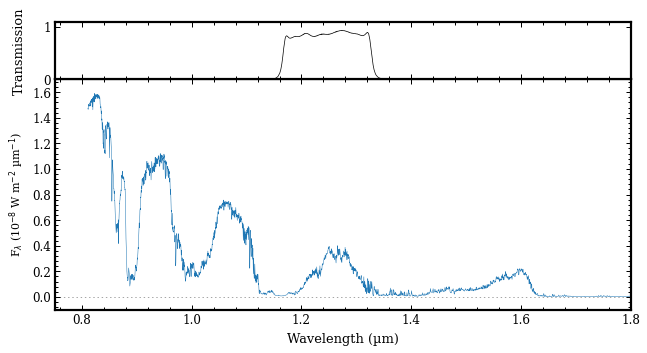

In [7]:
from IPython.display import Image
Image('spectrum.png')

## Synthetic flux and magnitude

Next, we use the [SyntheticPhotometry](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.photometry.SyntheticPhotometry) class to calculate the flux and magnitude for the [MKO/NSFCam.J](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=MKO/NSFCam.J&&mode=browse&gname=MKO&gname2=NSFCam#filter) filter. We first create and instance of [SyntheticPhotometry](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.photometry.SyntheticPhotometry) with the filter name from the SVO website.

In [8]:
synphot = species.SyntheticPhotometry('MKO/NSFCam.J')

The average J-band flux is calculated with the [spectrum_to_flux](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.photometry.SyntheticPhotometry.spectrum_to_flux) method. The error on the synthetic flux is estimated with Monte Carlo sampling of the input spectrum.

In [9]:
j_flux = synphot.spectrum_to_flux(wavelength, flux, error=error)
print(f'Flux (W m-2 um-1) = {j_flux[0]:.2e} +/- {j_flux[1]:.2e}')

Flux (W m-2 um-1) = 1.80e-09 +/- 8.38e-14


Similarly, we calculate the synthetic magnitude with the [spectrum_to_flux](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.photometry.SyntheticPhotometry.spectrum_to_magnitude) method. Also the absolute magnitude can be calculated by providing the distance and uncertainty (set to `None` in the example). In [species](https://species.readthedocs.io/en/latest/species.html), the magnitude is defined relative to Vega, which is assumed to have a magnitude of 0.03 in all filters. For the selected J-band filter, Jupiter has a magnitude of 0.59 so the planet is comparable in brightness to Vega.

In [10]:
j_mag, _ = synphot.spectrum_to_magnitude(wavelength, flux, error=error, distance=None)
print(f'Apparent magnitude = {j_mag[0]:.2f} +/- {j_mag[1]:.2e}')

Adding Vega spectrum... [DONE]
Apparent magnitude = 0.59 +/- 5.07e-05
